In [3]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, conv1d, relu_, sigmoid, hardtanh,  relu, unfold, fold, softmax
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import seaborn as sns
import pickle as pkl
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [4]:
def printgradnorm(self, grad_input, grad_output):
    print('Inside class:' + self.__class__.__name__)
    print('')
    print('grad_input: ', type(grad_input))
    print('grad_input[0]: ', type(grad_input[0]))
    print('grad_output: ', type(grad_output))
    print('grad_output[0]: ', type(grad_output[0]))
    print('')
    print('grad_input size:', grad_input[0].size())
    print('grad_output size:', grad_output[0].size())
    print('grad_input norm:', grad_input[0].norm())



In [57]:
def kWinnerTakeAll(tensor, k):
    values, indices = torch.topk(tensor, tensor.shape[-1] - k, largest=False)
    tensor[indices] = 0
    return tensor

In [58]:
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False, circular=False):
    trajectory = np.zeros((int(length), 2))
    turns = np.zeros((int(length)))
    if circular:
        r = np.sqrt(np.random.rand())*width
        angle = np.random.rand()*2.*np.pi
        x = np.cos(angle)*r
        y = np.sin(angle)*r
    else:
        x = np.random.rand()*width
        y = np.random.rand()*width
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        oldDir = direction
        recenter = 0
        patience = 0
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = ((recenter + (np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability + patience))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if circular:
                position = (movement[0] + x)**2 + (movement[1] + y)**2
                print(np.sqrt(position), width)
                inBounds = np.sqrt(position) < width
            else:
                inBounds = 0 < (movement[0] + x) < width and 0 < (movement[1] + y) < width
            if inBounds or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                turns[i] = np.abs(oldDir - direction)
                oldDir = direction
                break
            else:
                patience += .5
                recenter = oldDir
                

    return(trajectory, turns)

In [73]:
class L6L4Network(torch.nn.Module):
    def __init__(self,
                 numL6=500,
                 minicols=100,
                 cellsPerMinicolumn=10,
                 dendrites=1000,
                 numGaussians=10,
                 placeSigma=.01,
                 envSize=1.,
                 boostingAlpha=.01,
                 circular=False,
                 BCMLearningRate=.01,
                 BCMAlpha=.1,
                 SGDLearningRate=.01,
                 L6Sparsity=.2,
                 ):
        
        super(L6L4Network, self).__init__()
        self.minicols = minicols
        self.numL6 = numL6
        self.cellsPerMinicolumn = cellsPerMinicolumn
        self.numDendrites = dendrites
        self.numGaussians = numGaussians
        self.placeSigma=placeSigma
        self.envSize = envSize
        self.boostingAlpha = boostingAlpha
        self.BCMLearningRate = BCMLearningRate
        self.SGDLearningRate = SGDLearningRate
        self.BCMAlpha = BCMAlpha
        self.L6K = int(numL6*L6Sparsity)
        
        self.L6 = torch.nn.RNNCell(dendrites + 2, numL6)
        if device == torch.device('cuda'):
            self.L6 = self.L6.cuda()

        self.L4DendriteWeights = torch.zeros((minicols*cellsPerMinicolumn, dendrites), device=device, dtype=torch.float, 
                                            requires_grad=True)
        self.L4Dendrites = torch.zeros((dendrites, numL6), device=device, dtype=torch.float, 
                                      requires_grad=True)
        
        #self.L6DendriteWeights = torch.zeros((L6, dendrites), device=device, dtype=torch.float)
        self.L6Dendrites = torch.zeros((dendrites, minicols*cellsPerMinicolumn), device=device, dtype=torch.float, 
                                      requires_grad=True)
        
        
        torch.nn.init.kaiming_normal_(self.L4Dendrites)
        torch.nn.init.kaiming_normal_(self.L6Dendrites)
        torch.nn.init.kaiming_normal_(self.L4DendriteWeights)
        
        self.zero = torch.zeros((1,), device=device, dtype=torch.float)
        
        
        self.normalization = torch.nn.LayerNorm(numL6, elementwise_affine=False)
        
        if circular:
            angles = np.random.rand(minicols, numGaussians)*2*np.pi
            radii = np.sqrt(np.random.rand(minicols, numGaussians))*self.envSize
            xComp = np.cos(angles)
            yComp = np.sin(angles)
            places = np.stack([xComp*radii, yComp*radii], axis=-1)
            self.places = torch.tensor(places,
                                       device=device,
                                       dtype=torch.float,
                                       requires_grad=False)
        else:
            self.places = torch.tensor(np.random.rand(minicols, numGaussians, 2)*self.envSize,
                                       device=device,
                                       dtype=torch.float,
                                       requires_grad=False)
        self.circular = circular
        
    def forward(self,
                velocities,
                feedforwards,
                hidden,
                L4,
                L4DendriteHistory,
                L6DendriteHistory,
                L4History,
                BCML4History):
        
        cost = torch.zeros((1,), device=device, dtype=torch.float)
        for i in range(velocities.shape[0]):
            vel = velocities[i]
            feedforward = feedforwards[i]
            L6DendriteActivations = self.L6Dendrites@(L4.view(L4.numel()))
            relu_(L6DendriteActivations)
            input = torch.cat((L6DendriteActivations, vel))
            hidden = self.L6(input.view(1, input.numel()), hidden)
            hidden = self.normalization(hidden)
            hidden = kWinnerTakeAll(hidden, self.L6K)

            L4DendriteActivations = self.L4Dendrites@(hidden.view(hidden.numel()))
            #L4DendriteActivations = (L4DendriteActivations**2) + 1.
            L4Predictions = (self.L4DendriteWeights@L4DendriteActivations).view(L4.shape)
            L4Predictions = L4Predictions*(1 - (L4History + 0.01))
            relu_(L4Predictions)
            #plt.matshow(L4Predictions.detach().cpu().numpy()); plt.show()
            L4Predictions = softmax(L4Predictions**2 + 1., dim = -1)
            #plt.matshow(L4Predictions.detach().cpu().numpy()); plt.show()
            L4 = feedforward[:, None]*L4Predictions

            cost = cost + torch.sum(L4 ** 0.5) 
            
            with torch.no_grad():
                L4History = L4Predictions*self.boostingAlpha + L4History*(1 - self.boostingAlpha)
                BCML4History = (L4Predictions **2)*self.BCMAlpha + BCML4History*(1 - self.BCMAlpha)
                L4DendriteHistory = (L4DendriteActivations **2)*self.BCMAlpha +\
                    L4DendriteHistory*(1 - self.BCMAlpha)
                L6DendriteHistory = (L6DendriteActivations **2)*self.BCMAlpha +\
                    L6DendriteHistory*(1 - self.BCMAlpha)
                
                
                if torch.isnan(hidden).any() or \
                    torch.isnan(L4).any() or \
                    torch.isnan(L4DendriteActivations).any(): 
                    import ipdb; ipdb.set_trace()
                self.L4Dendrites = self.L4Dendrites +\
                    self.BCMLearningRate*self.BCMLearn(hidden, L4DendriteActivations, L4DendriteHistory)
                self.L4DendriteWeights = self.L4DendriteWeights +\
                    self.BCMLearningRate*self.BCMLearn(L4DendriteActivations, L4.view(L4.numel()), BCML4History)
                self.L6Dendrites = self.L6Dendrites +\
                    self.BCMLearningRate*self.BCMLearn(L4, L6DendriteActivations, L6DendriteHistory)

                relu_(self.L4DendriteWeights)
                relu_(self.L4Dendrites)
        
        return (torch.sum(cost),
                hidden.detach(),
                L4.detach(),
                L4DendriteHistory.detach(),
                L6DendriteHistory.detach(),
                L4History.detach(),
                BCML4History.detach())

    
    def BCMLearn(self, presyn, postsyn, history):
        """
        Return: update
        """
        postsyn = postsyn.view(postsyn.numel())
        presyn = presyn.view(presyn.numel())
        history = history.view(history.numel())
        delta = torch.ger(postsyn*(postsyn - history), presyn)/(history[:, None] + 0.001)
        
        return (delta * self.BCMLearningRate)    
    

    def learn(self, runningTime, seqLen, speed, stability):
        L4 = torch.zeros((self.minicols, self.cellsPerMinicolumn), device=device, dtype=torch.float,)
        L4History = torch.zeros((self.minicols, self.cellsPerMinicolumn), device=device, dtype=torch.float,)
        BCML4History = torch.zeros((self.minicols, self.cellsPerMinicolumn), device=device, dtype=torch.float)
        L6History = torch.zeros((self.minicols, self.cellsPerMinicolumn), device=device, dtype=torch.float)
        L4DendriteHistory = torch.zeros((self.numDendrites), device=device, dtype=torch.float)
        L6DendriteHistory = torch.zeros((self.numDendrites), device=device, dtype=torch.float)
        hidden = torch.zeros((1, self.numL6,), device=device, dtype=torch.float, requires_grad=True)
        
        
        torch.nn.init.uniform_(L4)
        torch.nn.init.uniform_(L4History)
        torch.nn.init.uniform_(BCML4History)
        torch.nn.init.uniform_(L6History)
        torch.nn.init.uniform_(L4DendriteHistory)
        torch.nn.init.uniform_(L6DendriteHistory)
        torch.nn.init.uniform_(hidden)
        
        trajectory, turns = buildTrajectory(runningTime,
                                            speed,
                                            width=self.envSize,
                                            wrap=False,
                                            directionStability=stability,
                                            circular=self.circular)
        
        velocities = torch.tensor(np.diff(trajectory, axis=0), device=device, dtype=torch.float,
                                 requires_grad=False)
        trajectory = torch.tensor(trajectory, device=device, dtype=torch.float,
                                 requires_grad=False)
        
        cost = torch.zeros((1), device=device, dtype=torch.float, requires_grad=False)
        for run in np.arange((runningTime - 1)/seqLen):
            feedforwards = []
            vels = []
            
            for t in range(seqLen):
                i = int(t + run*seqLen)
                pos = trajectory[i]
                vel = velocities[i]

                distances = torch.zeros((self.minicols,
                                         self.numGaussians, 2),
                                         device=device,
                                         dtype=torch.float,
                                         requires_grad=False)

                distances[:, :, 0] = torch.abs(self.places[:, :, 0] - pos[0])
                distances[:, :, 1] = torch.abs(self.places[:, :, 1] - pos[1])


                activity = torch.exp(-1.*torch.norm(distances, 2, dim=-1)/(2*(self.placeSigma)))
                activity = torch.sum(activity, dim=-1)
                
                feedforwards.append(activity)
                vels.append(vel)
                
            vels = torch.stack((vels), dim=0)
            feedforwards = torch.stack((feedforwards), dim=0)
            
            (cost,
            hidden,
            L4,
            L4DendriteHistory,
            L6DendriteHistory,
            L4History,
            BCML4History) = self.forward(vels,
                            feedforwards,
                            hidden,
                            L4,
                            L4DendriteHistory,
                            L6DendriteHistory,
                            L4History,
                            BCML4History)  

            print(run, cost.detach().cpu().numpy())
            cost.backward()
            with torch.no_grad():
                for param in self.L6.parameters():
                    if torch.isnan(self.SGDLearningRate*param.grad).any():
                        print("NANs in gradient at {}!".format(run))
                        import ipdb; ipdb.set_trace()
                    else:
                        param -= self.SGDLearningRate*param.grad
                    param.grad.zero_()
            velocities=velocities.detach()
            trajectory=trajectory.detach()
            self.places=self.places.detach()
            hidden = hidden.detach()
            L4 = L4.detach()
            L4DendriteHistory = L4DendriteHistory.detach()
            L6DendriteHistory = L6DendriteHistory.detach()
            BCML4History = BCML4History.detach()
            cost = cost.detach()
            self.L4DendriteWeights = self.L4DendriteWeights.detach()
            self.L4Dendrites = self.L4Dendrites.detach()
            self.L6Dendrites = self.L6Dendrites.detach() 
        return(L4)

<IPython.core.display.Javascript object>


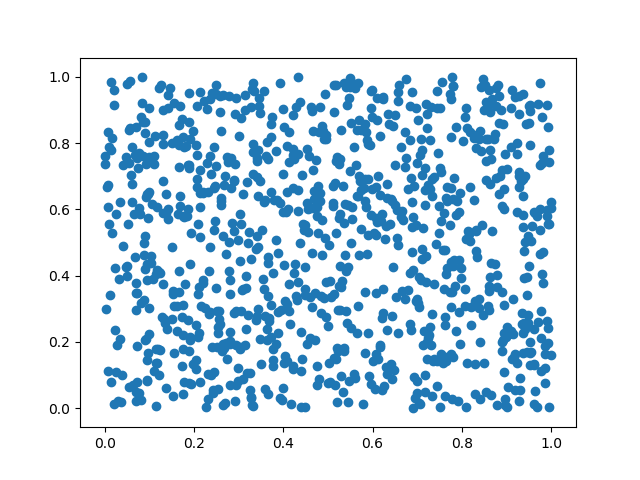

<IPython.core.display.Javascript object>


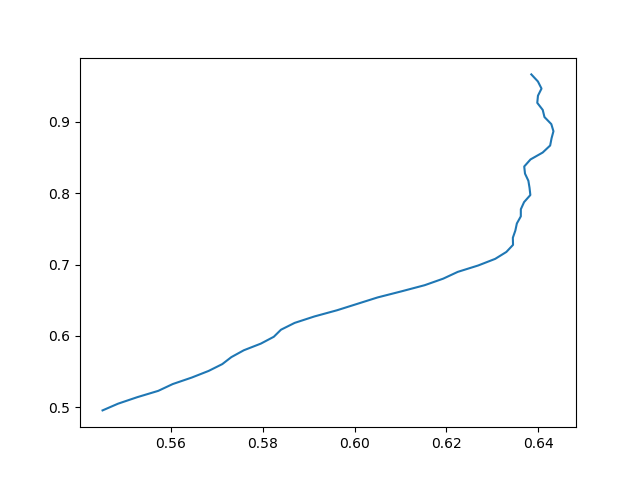

In [79]:
net = L6L4Network(
                 numL6=100,
                 minicols=100,
                 cellsPerMinicolumn=10,
                 dendrites=100,
                 numGaussians=10,
                 placeSigma=.05,
                 envSize=1.,
                 boostingAlpha=.05,
                 circular=False,
                 BCMLearningRate=.001,
                 BCMAlpha=.1,
                 SGDLearningRate=.0001,
                 L6Sparsity=.5,
                 )

places = net.places.view(net.minicols*net.numGaussians, 2)
plt.figure()
plt.scatter(places[:, 0], places[:, 1])
plt.show()


trajectory, turns = buildTrajectory(50,
                                    .01,
                                    width=net.envSize,
                                    wrap=False,
                                    directionStability=.95,
                                    circular=net.circular)

plt.figure()
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()

In [80]:
for i in range(1):
#    print(i*5)
    result = net.learn(1001, 1, .01, .95)
#    print(torch.mean(net.L4Dendrites).cpu().numpy())
#     print(torch.mean(net.L4DendriteWeights).cpu().numpy())
#     print(torch.mean(net.L6Dendrites).cpu().numpy())

0.0 181.14766
1.0 184.1422
2.0 187.18106
3.0 190.09375
4.0 192.81564
5.0 195.30405
6.0 197.57317
7.0 199.70087
8.0 201.61824
9.0 203.3176
10.0 204.97769
11.0 206.59311
12.0 208.08209
13.0 209.53635
14.0 210.92287
15.0 212.2196
16.0 213.45006
17.0 214.59193
18.0 215.61095
19.0 216.46202
20.0 217.24619
21.0 218.03484
22.0 211.3505
23.0 208.07388
24.0 201.3559
25.0 198.92917
26.0 220.76836
27.0 209.88557
28.0 203.10583
29.0 194.2413
30.0 199.40363
31.0 222.94502
32.0 210.42538
33.0 191.68094
34.0 223.64536
35.0 204.1549
36.0 182.41125
37.0 225.12718
38.0 204.20251
39.0 174.0396
40.0 227.80014
41.0 196.18585
42.0 169.8723
43.0 231.7072
44.0 198.57173
45.0 167.26099
46.0 236.6748
47.0 190.04752
48.0 166.59259
49.0 241.45691
50.0 181.25128
51.0 164.9491
52.0 244.52747
53.0 175.52786
54.0 165.11412
55.0 247.06374
56.0 171.19955
57.0 164.70299
58.0 248.46408
59.0 167.98726
60.0 163.96045
61.0 247.51566
62.0 164.48846
63.0 161.8039
64.0 244.90114
65.0 161.37888
66.0 159.33426
67.0 241.25105
68.

529.0 120.72392
530.0 119.061386
531.0 121.07764
532.0 122.47589
533.0 123.25741
534.0 123.15044
535.0 123.1845
536.0 123.292625
537.0 123.27052
538.0 123.06811
539.0 122.936455
540.0 122.3864
541.0 122.116936
542.0 121.49094
543.0 121.03981
544.0 120.90445
545.0 120.40917
546.0 119.946434
547.0 119.341
548.0 119.03003
549.0 118.82771
550.0 118.448105
551.0 118.400604
552.0 118.28523
553.0 117.56202
554.0 116.37468
555.0 114.97894
556.0 113.499405
557.0 111.78494
558.0 110.369934
559.0 108.91437
560.0 107.11786
561.0 104.90767
562.0 102.907104
563.0 105.2651
564.0 106.969574
565.0 108.750015
566.0 110.354324
567.0 111.31475
568.0 111.86065
569.0 112.30115
570.0 112.4935
571.0 112.81432
572.0 112.74612
573.0 111.87985
574.0 110.20983
575.0 113.41975
576.0 116.29887
577.0 118.920456
578.0 121.35355
579.0 123.701996
580.0 125.82247
581.0 127.45719
582.0 129.09625
583.0 130.59418
584.0 132.34705
585.0 133.74586
586.0 134.87198
587.0 135.91771
588.0 137.14505
589.0 138.53735
590.0 139.50902

<IPython.core.display.Javascript object>


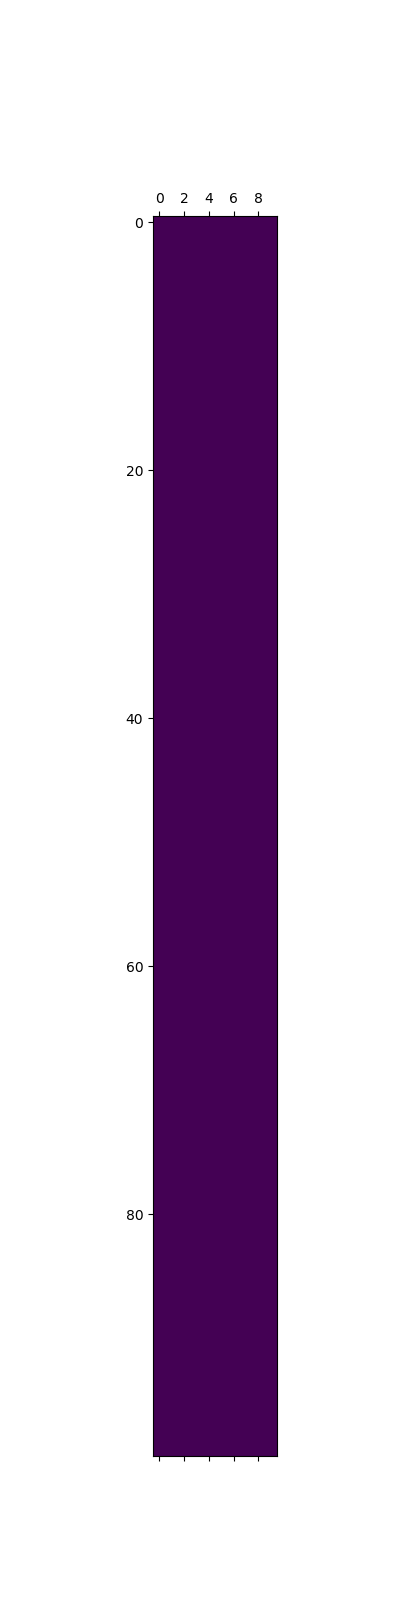

In [69]:
plt.matscc
chow(result)

In [ ]:
torch.max(result)

<IPython.core.display.Javascript object>


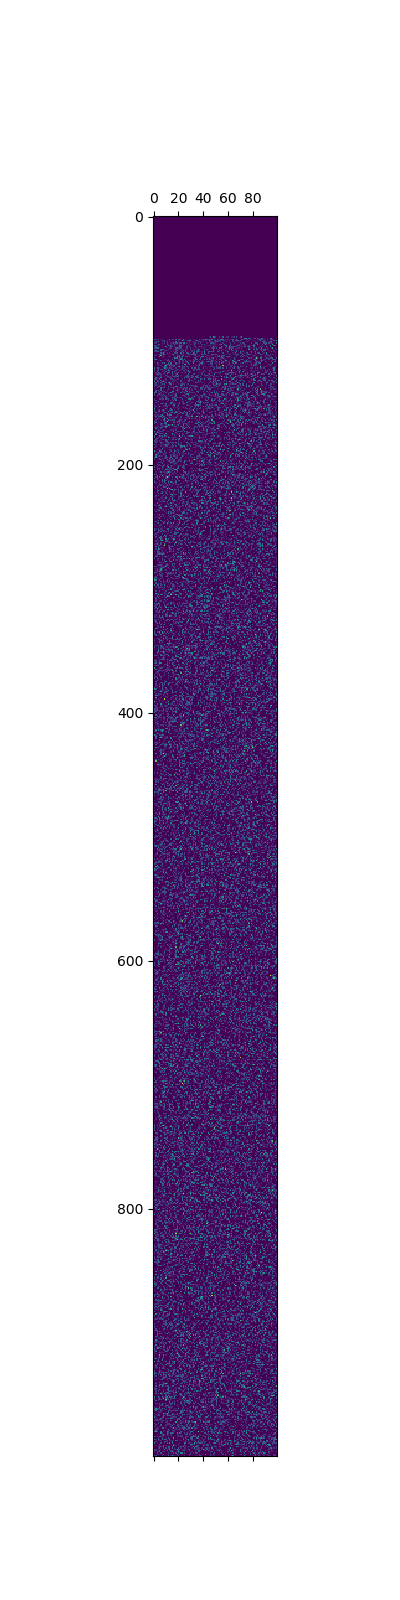

In [77]:
plt.matshow(net.L4DendriteWeights.detach())